<a href="https://colab.research.google.com/github/mijanr/GANs/blob/master/cGAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [149]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [150]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [151]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [152]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


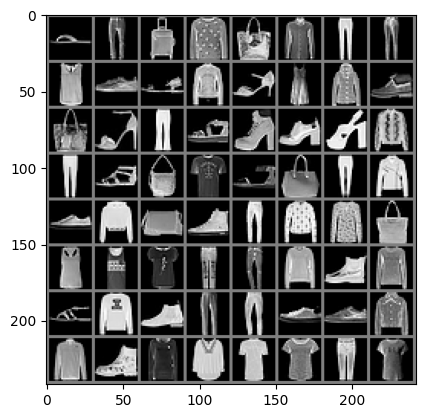

In [153]:
imshow(trainloader)

In [154]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [155]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(class_num, class_num)
        #output size = batch_size x 1x 28 x 28
        self.sequential = nn.Sequential(
            nn.Linear(100 + class_num, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=28*28, bias=True),
            nn.Tanh()
        )
    def forward(self, x, label):
        label = self.embed(label)
        x = torch.cat([x, label], 1)
        x = self.sequential(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [158]:
generator = Generator().to(device)

In [159]:
#feed a random noise and a label to the generator
noise = torch.randn(64, 100, device=device)
labels = torch.randint(0, 10, (64,), device=device)
fake_images = generator(noise, labels)
print(fake_images.shape)

torch.Size([64, 1, 28, 28])


In [160]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(class_num, class_num)
        self.sequential = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, label):
        x = x.view(-1, 784)
        label = self.embed(label)
        x = torch.cat((x, label), dim=1)
        x = self.sequential(x)
        return x

In [161]:
discriminator = Discriminator().to(device)

In [162]:
#feed the fake image to the discriminator
output = discriminator(fake_images, labels)
print(output.shape)

torch.Size([64, 1])


In [163]:
#training
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [177]:
#training loop
num_epochs = 50
for epoch in range(num_epochs):
    for images, labels in trainloader:
        #train discriminator
        discriminator.zero_grad()
        real_images = images.to(device)
        real_labels = labels.to(device)
        real_output = discriminator(real_images, real_labels)
        real_loss = criterion(real_output, torch.ones_like(real_output))
        real_loss.backward()

        noise = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_images = generator(noise, fake_labels)
        fake_output = discriminator(fake_images, fake_labels)
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        fake_loss.backward()

        optimizerD.step()

        #train generator
        generator.zero_grad()
        noise = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_images = generator(noise, fake_labels)
        fake_output = discriminator(fake_images, fake_labels)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        optimizerG.step()
        #print loss
        if (epoch + 1) % 10 == 0:
            print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch + 1, num_epochs, real_loss.item() + fake_loss.item(), g_loss.item()))

Epoch [10/50], d_loss: 1.0420, g_loss: 1.1581
Epoch [10/50], d_loss: 1.1260, g_loss: 1.1843
Epoch [10/50], d_loss: 0.9864, g_loss: 1.2628
Epoch [10/50], d_loss: 1.1748, g_loss: 1.3471
Epoch [10/50], d_loss: 1.1080, g_loss: 1.2332
Epoch [10/50], d_loss: 1.1152, g_loss: 0.9360
Epoch [10/50], d_loss: 0.9415, g_loss: 1.0572
Epoch [10/50], d_loss: 0.9978, g_loss: 1.2492
Epoch [10/50], d_loss: 1.0019, g_loss: 1.0682
Epoch [10/50], d_loss: 0.8799, g_loss: 1.0268
Epoch [10/50], d_loss: 0.9813, g_loss: 1.3186
Epoch [10/50], d_loss: 1.0134, g_loss: 1.3360
Epoch [10/50], d_loss: 1.0752, g_loss: 0.9945
Epoch [10/50], d_loss: 1.0448, g_loss: 1.0898
Epoch [10/50], d_loss: 1.0913, g_loss: 1.1705
Epoch [10/50], d_loss: 0.9616, g_loss: 1.3915
Epoch [10/50], d_loss: 1.2535, g_loss: 1.0527
Epoch [10/50], d_loss: 1.1494, g_loss: 0.9759
Epoch [10/50], d_loss: 1.2483, g_loss: 1.2607
Epoch [10/50], d_loss: 0.9898, g_loss: 1.3744
Epoch [10/50], d_loss: 1.0605, g_loss: 1.0337
Epoch [10/50], d_loss: 1.0616, g_l

In [185]:
#gernerate image
noise = torch.randn(64, 100, device=device)
label = torch.randint(9, 10, (64,), device=device)
fake_image = generator(noise, label)
fake_image = fake_image.view(fake_image.size(0), 28, 28)
fake_image = fake_image.cpu().detach().numpy()

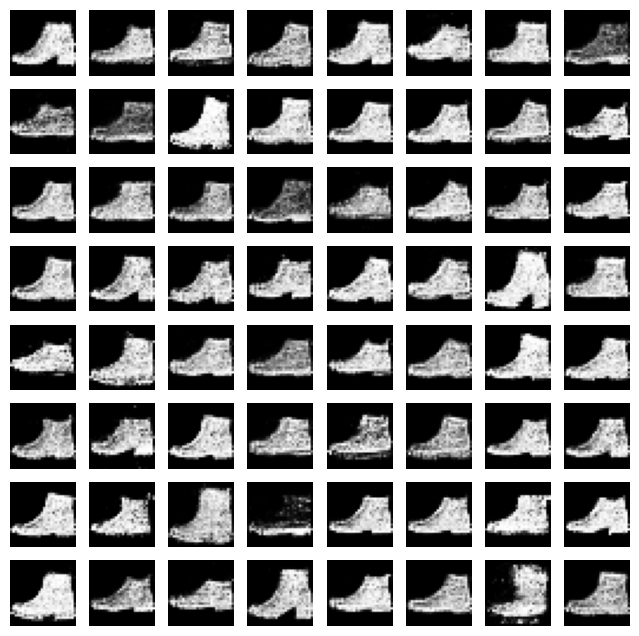

In [186]:
#visualize the generated image
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(fake_image[i], cmap='gray')
    plt.axis('off')
plt.show()

In [187]:
class_list

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']